In [1]:
'''
Import necessary packages
'''
import numpy as np
import scipy
import scipy.integrate
import scipy.signal
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib
import pickle

from ip3_ca_ode import *

#set figure font sizes for readability
font = {'size' : 30,
       'family': 'serif',
       'sans-serif': ['Helvetica']}
matplotlib.rc('font', **font)
matplotlib.rc('text', usetex=True)
color_cycle = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', 
               '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

In [149]:
def compute_delay():
    '''
    Compute the delay time in accordance with the description by "2. Detecting how long delays last"
    
    return: 
        t_to_stable_peak, t_to_stable_peak_from_first
        t_to_stable_peak: time to first stable peak from t=0
        t_to_stable_peak_from_first: time to first stable peak from first peak
    '''
    peaks = scipy.signal.find_peaks(c)[0]
    troughs = scipy.signal.find_peaks(-c)[0]

    if(len(peaks) < 10):
        #not enough peaks found
        return 0, 0
    
    stable_peak = peaks[-2]
    first_peak = peaks[0]
    stable_trough = troughs[np.argmax(t[troughs] > t[peaks[-3]])]
    c_stable_peak = c[stable_peak]

    #check if troughs are sufficiently deep
    if(not c[stable_trough] < c[stable_peak] * 0.9):
        return 0, 0
    
    c_stable_peak = c[stable_peak]
    
    #find the first time peaks reach +/- 5% of stable peak
    #note that we will not count the first peak
    #need three in a row
    successes = 0
    for i, peak in enumerate(peaks[1:]):
        peak_diff = c_stable_peak - c[peak]
        peak_diff_percent = abs(peak_diff / c_stable_peak)
    #         print(peak_diff_percent)
        if(peak_diff_percent < 0.01):
            successes += 1
        else:
            successes = 0
        if(successes > 2):
            first_stable_peak = peaks[i-3]
            break
    
    if(successes > 2):
        t_to_stable_peak = t[first_stable_peak]
        t_to_stable_peak_from_first = t[first_stable_peak] - t[first_peak]

        return t_to_stable_peak, t_to_stable_peak_from_first
    
    else:
        #no first stable peak found
        return 0, 0

# Detecting how long delays last

We will use scipy to find where the peaks in calcium are. We will attempt to find when the calcium peaks are within 95% of the height of the "stable peak". We will define the "stable peak" as the second to last one (since we don't want to choose a peak that is shorter because the G* signal cuts out too soon). Call the first peak to pass the 95% mark the "first stable peak".

Then we want to check how long it takes to get to the "first stable peak". We will check how long it takes from t=0, and how long it takes from the first peak overall, just in case that matters.

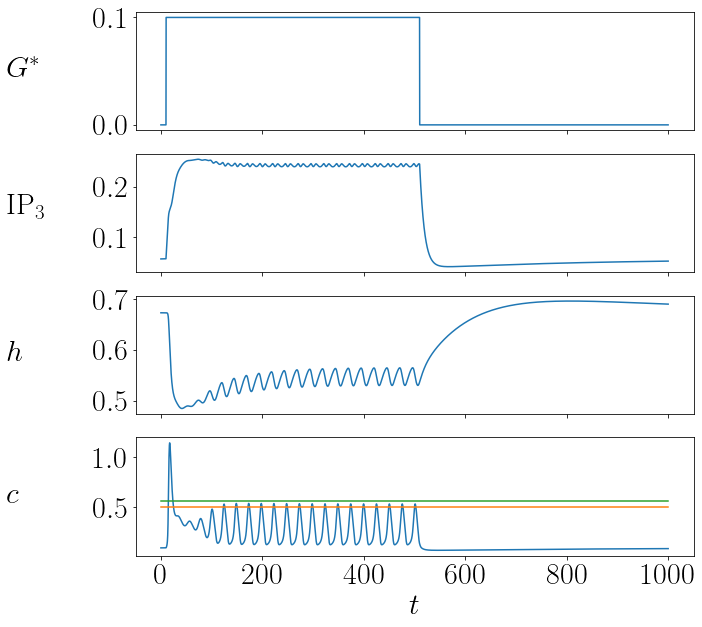

In [22]:
input_duration = 500
input_max = 0.1
run_Gstar_controlled_experiment('pulse')
fig, ax = plt.subplots(4, 1, sharex=True, figsize=(10,10))

plot_experiment_plots(['Gstar', 'p', 'h', 'c'], ax)
ax[-1].plot([t[0],t[-1]], [c[stable_peak]*0.95, c[stable_peak]*0.95])
ax[-1].plot([t[0],t[-1]], [c[stable_peak]*1.05, c[stable_peak]*1.05])

In [180]:
Gstars = np.linspace(0.1, 0.25, 40)
v_3ks = np.linspace(0, 2, 30)
v_delta = 0

x, y = np.meshgrid(Gstars, v_3ks)

abs_delays = np.zeros(x.shape)
rel_delays = np.zeros(x.shape)

num_trials = 0
input_duration=2000

for i in range(x.shape[0]):
    for j in range(x.shape[1]):
        num_trials += 1
        if(num_trials % 20 == 0):
            print(num_trials)
            
        v_3k = y[i,j]
        input_max = x[i,j]
        
        run_Gstar_controlled_experiment('pulse', max_step=0.5, t_f=2000)
        t_abs_delay, t_rel_delay = compute_delay()
        abs_delays[i,j] = t_abs_delay
        rel_delays[i,j] = t_rel_delay

20
40
60
80
100
120
140
160
180
200
220
240
260
280
300
320
340
360
380
400
420
440
460
480
500
520
540
560
580
600
620
640
660
680
700
720
740
760
780
800
820
840
860
880
900
920
940
960
980
1000
1020
1040
1060
1080
1100
1120
1140
1160
1180
1200


## Running delay computation over ranges of v_3k, v_delta, Gstar

In [329]:
Gstars = np.linspace(0, 0.25, 50)
# v_3ks = np.linspace(0, 2, 30)
v_3k = 0
v_deltas = np.linspace(0, 0.02, 20)

#zoomed v_deltas
# Gstars = np.linspace(0.16, 0.2, 30)
# v_deltas = np.linspace(0.004, 0.008, 30)

#zoomed2 v_deltas
Gstars = np.linspace(0.1, 0.12, 30)
# v_deltas = np.linspace(0.017, 0.02, 20)
v_deltas = np.array([0.02])

x, y = np.meshgrid(Gstars, v_deltas)

abs_delays = np.zeros(x.shape)
rel_delays = np.zeros(x.shape)

num_trials = 0
input_duration=2000

for i in range(x.shape[0]):
    for j in range(x.shape[1]):
        num_trials += 1
        if(num_trials % 20 == 0):
            print(num_trials)
            
        v_delta = y[i,j]
        input_max = x[i,j]
        
        run_Gstar_controlled_experiment('pulse', max_step=0.5, t_f=2000)
        t_abs_delay, t_rel_delay = compute_delay()
        abs_delays[i,j] = t_abs_delay
        rel_delays[i,j] = t_rel_delay

20
40
60
80
100
120
140
160
180
200
220
240
260
280
300
320
340
360
380
400
420
440
460
480
500
520
540
560
580
600


In [181]:
#add results to computed delays dictionary
computed_delays = pickle.load(open('data/computed_delays/computed_delays', 'rb'))

computed_delays[v_delta] = {
    'v_3k': y,
    'Gstar': x,
    'rel_delays': rel_delays,
    'abs_delays': abs_delays
}

pickle.dump(computed_delays, open('data/computed_delays/computed_delays', 'wb'))

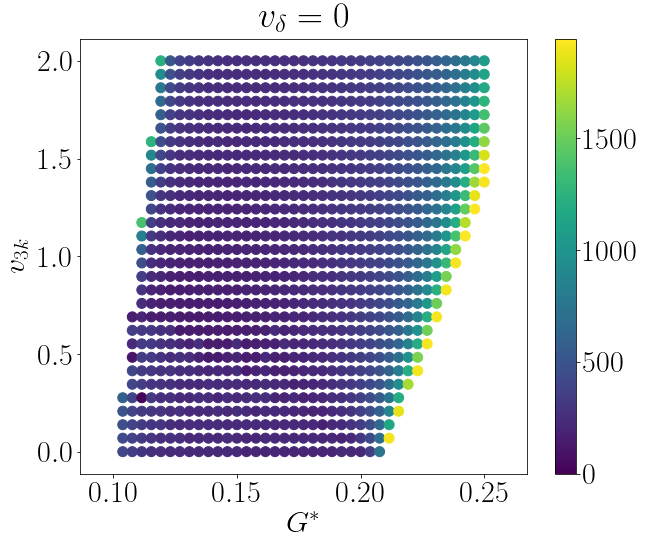

In [182]:
computed_delays = pickle.load(open('data/computed_delays/computed_delays', 'rb'))
plot_vdelta = 0

x = computed_delays[plot_vdelta]['Gstar']
y = computed_delays[plot_vdelta]['v_3k']
c = computed_delays[plot_vdelta]['abs_delays']


plt.figure(figsize=(10,8))

plt.title(r'$v_{\delta} = 0$')
plt.scatter(x, y, c=c, s=np.ceil(c/10000) * 100)
plt.xlabel(r'$G^*$')
plt.ylabel(r'$v_{3k}$')
plt.colorbar()

plt.savefig('figures/delay_plots/v_delta_0.png', bbox_inches='tight')

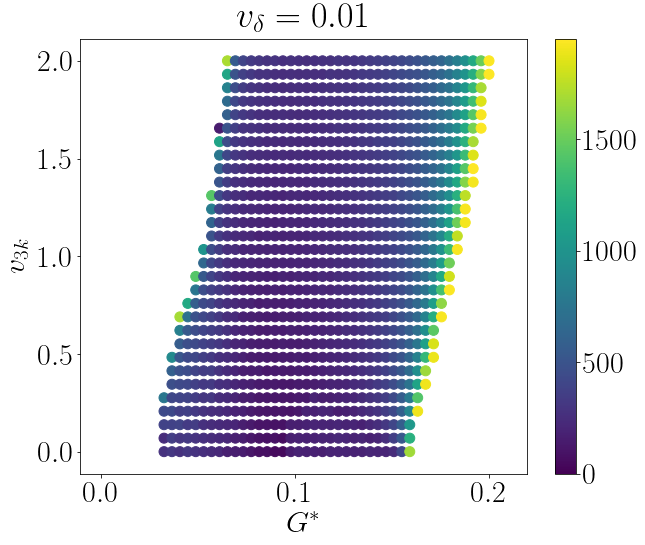

In [173]:
computed_delays = pickle.load(open('data/computed_delays/computed_delays', 'rb'))
plot_vdelta = 0.01

x = computed_delays[plot_vdelta]['Gstar']
y = computed_delays[plot_vdelta]['v_3k']
c = computed_delays[plot_vdelta]['abs_delays']


plt.figure(figsize=(10,8))

plt.title(r'$v_{\delta} = 0.01$')
plt.scatter(x, y, c=c, s=np.ceil(c/10000) * 100)
plt.xlabel(r'$G^*$')
plt.ylabel(r'$v_{3k}$')
plt.colorbar()

plt.savefig('figures/delay_plots/v_delta_0.01.png', bbox_inches='tight')

## Delays in v_delta

In [330]:
#add results to computed delays dictionary
computed_delays_vdelta = pickle.load(open('data/computed_delays/computed_delays_vdelta', 'rb'))

computed_delays_vdelta['0_zoom2'] = {
    'v_delta': y,
    'Gstar': x,
    'rel_delays': rel_delays,
    'abs_delays': abs_delays
}

pickle.dump(computed_delays_vdelta, open('data/computed_delays/computed_delays_vdelta', 'wb'))

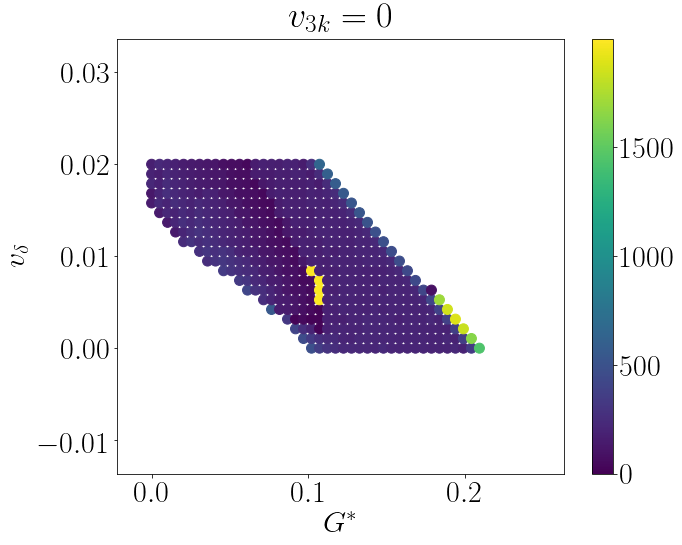

In [225]:
computed_delays_vdelta = pickle.load(open('data/computed_delays/computed_delays_vdelta', 'rb'))
plot_v3k = 0

x = computed_delays_vdelta[plot_v3k]['Gstar']
y = computed_delays_vdelta[plot_v3k]['v_delta']
c = computed_delays_vdelta[plot_v3k]['abs_delays']


plt.figure(figsize=(10,8))

plt.title(r'$v_{3k} = 0$')
plt.scatter(x, y, c=c, s=np.ceil(c/10000) * 100)
plt.xlabel(r'$G^*$')
plt.ylabel(r'$v_{\delta}$')
plt.colorbar()

plt.savefig('figures/delay_plots/v_3k_0.png', bbox_inches='tight')

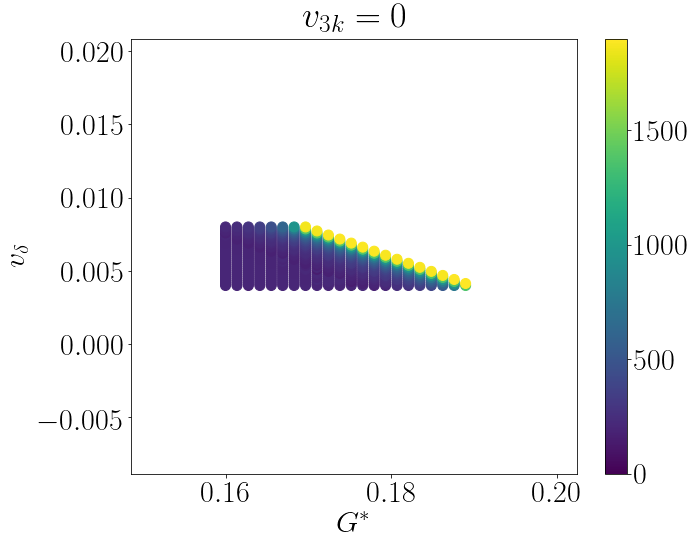

In [271]:
computed_delays_vdelta = pickle.load(open('data/computed_delays/computed_delays_vdelta', 'rb'))
plot_v3k = '0_zoom'

x = computed_delays_vdelta[plot_v3k]['Gstar']
y = computed_delays_vdelta[plot_v3k]['v_delta']
c = computed_delays_vdelta[plot_v3k]['abs_delays']


plt.figure(figsize=(10,8))

plt.title(r'$v_{3k} = 0$')
plt.scatter(x, y, c=c, s=np.ceil(c/10000) * 100)
plt.xlabel(r'$G^*$')
plt.ylabel(r'$v_{\delta}$')
plt.colorbar()

plt.savefig('figures/delay_plots/v_3k_0_zoom.png', bbox_inches='tight')

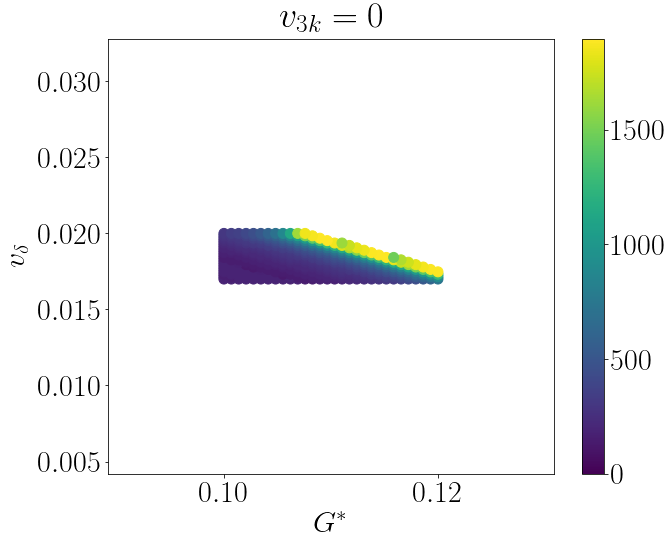

In [335]:
computed_delays_vdelta = pickle.load(open('data/computed_delays/computed_delays_vdelta', 'rb'))
plot_v3k = '0_zoom2'

x = computed_delays_vdelta[plot_v3k]['Gstar']
y = computed_delays_vdelta[plot_v3k]['v_delta']
c = computed_delays_vdelta[plot_v3k]['abs_delays']


plt.figure(figsize=(10,8))

plt.title(r'$v_{3k} = 0$')
plt.scatter(x, y, c=c, s=np.ceil(c/10000) * 100)
plt.xlabel(r'$G^*$')
plt.ylabel(r'$v_{\delta}$')
plt.colorbar()

plt.savefig('figures/delay_plots/v_3k_0_zoom.png', bbox_inches='tight')

In [224]:

computed_delays_vdelta = {
    'description': 'Delays computed for varying values of v_delta and G*, sorted by value of v_3k',
    0: {
        'v_delta': y,
        'Gstar': x,
        'rel_delays': rel_delays,
        'abs_delays': abs_delays
    }
}

pickle.dump(computed_delays_vdelta, open('data/computed_delays/computed_delays_vdelta', 'wb'))

## Experimental code to make sure delay computation is working as expected

Also using this to check specific trials to see if anything weird is going on

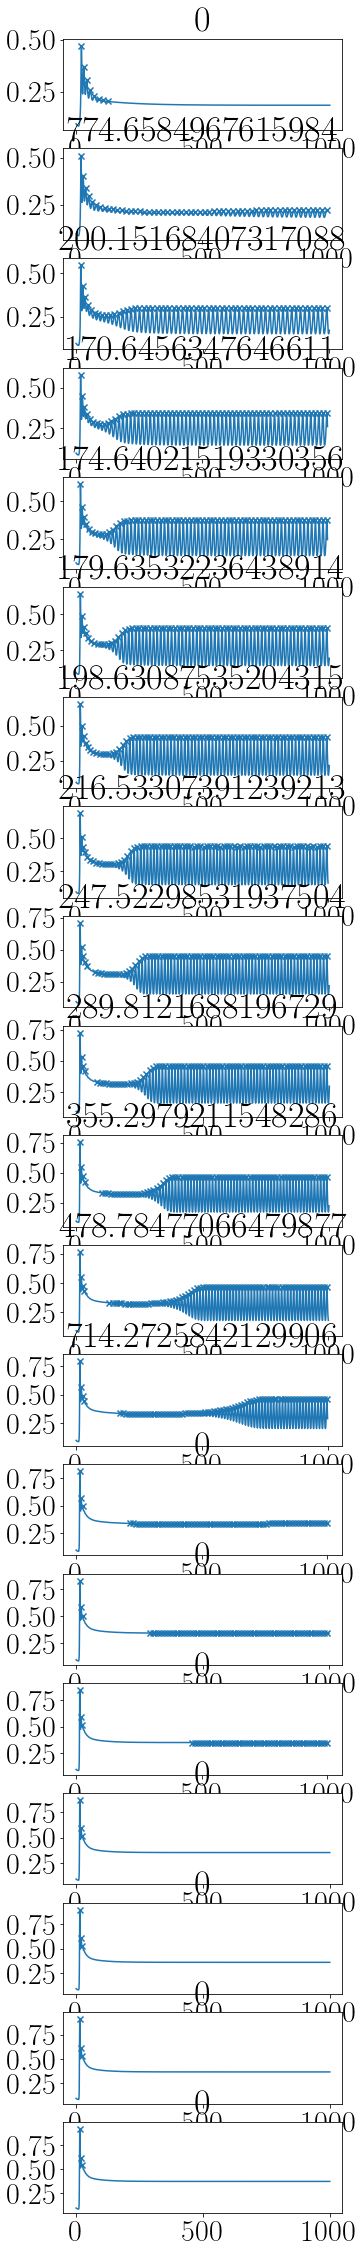

In [178]:
v_3k = 1
fig, ax = plt.subplots(20, 1, figsize=(5, 40))
for i, input_max in enumerate(np.linspace(0.1, 0.3, 20)):
    run_Gstar_controlled_experiment('pulse', t_f=1000, max_step=0.5)
    ax[i].plot(t, c)
    peaks = scipy.signal.find_peaks(c)[0]
    ax[i].scatter(t[peaks], c[peaks], marker='x')
    delay, _ = compute_delay()
    ax[i].set_title(str(delay))

(0, 0)
fail
39.561606066009844


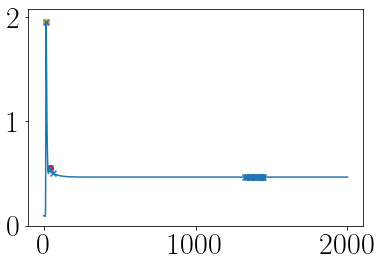

In [244]:
# Gstars = np.linspace(0.1, 0.3, 20)

# input_max = Gstars[-5]

Gstars[6][21]
v_3k = 0
v_delta = v_deltas[6][0]
run_Gstar_controlled_experiment('pulse', t_f=2000, max_step=0.5)
print(compute_delay())
plt.plot(t, c)

peaks = scipy.signal.find_peaks(c)[0]
troughs = scipy.signal.find_peaks(-c)[0]

if(len(peaks) < 3):
    #not enough peaks found
    print('fail')

stable_peak = peaks[-2]
first_peak = peaks[0]
stable_trough = troughs[np.argmax(t[troughs] > t[peaks[-3]])]
c_stable_peak = c[stable_peak]

#check if troughs are sufficiently deep
if(not c[stable_trough] < c[stable_peak] * 0.9):
    print('fail')

#find the first time peaks reach +/- 5% of stable peak
#note that we will not count the first peak
#need three in a row
successes = 0
for i, peak in enumerate(peaks[1:]):
    peak_diff = c_stable_peak - c[peak]
    peak_diff_percent = abs(peak_diff / c_stable_peak)
#         print(peak_diff_percent)
    if(peak_diff_percent < 0.01):
        successes += 1
    else:
        successes = 0
    if(successes > 2):
        first_stable_peak = peaks[i-3]
        break

plt.scatter(t[first_peak], c[first_peak], c='orange')
plt.scatter(t[stable_peak], c[stable_peak], c='green')
plt.scatter(t[first_stable_peak], c[first_stable_peak], c='red')
print(t[first_stable_peak])
# plt.scatter(t[troughs], c[troughs])
plt.scatter(t[peaks], c[peaks], marker='x')


In [288]:
v_3k = 0.1
v_delta = 0
Gstars = np.linspace(0.14, 0.17, 30)
delays = []
input_duration = 3000
for i, input_max in enumerate(Gstars):
    if(i % 5 == 0):
        print(i)
    run_Gstar_controlled_experiment('pulse', t_f=input_duration, max_step=0.5)
    abs_delay, rel_delay = compute_delay()
    delays.append(abs_delay)

0
5
10
15
20
25


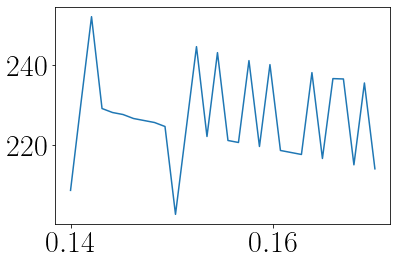

In [289]:
plt.plot(Gstars, delays)

In [297]:
v_3k = 0.1
Gstars = np.linspace(0.21, 0.215, 10)
delays = []
input_duration = 3000
for i, input_max in enumerate(Gstars):
    if(i % 5 == 0):
        print(i)
    run_Gstar_controlled_experiment('pulse', t_f=input_duration, max_step=0.5)
    abs_delay, rel_delay = compute_delay()
    delays.append(abs_delay)

0
5


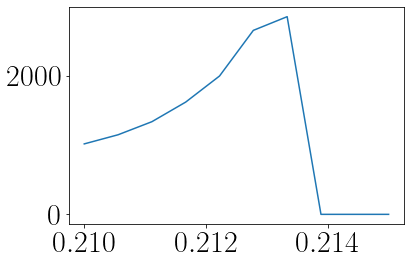

In [298]:
plt.plot(Gstars, delays)

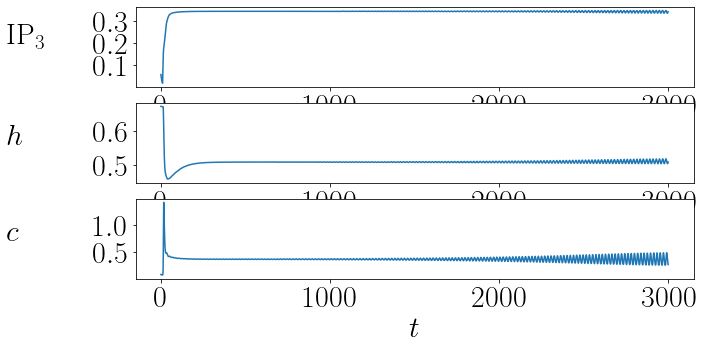

In [302]:
input_max = 0.213
run_Gstar_controlled_experiment('pulse', t_f=3000, max_step=0.05)

fig, ax = plt.subplots(3, 1, figsize=(10, 5))
plot_experiment_plots(['p', 'h', 'c'], ax, plot_input=False)

# Looking for parameter perturbations to induce stable fixed point

## p params

In [304]:
p_parameters = ['v_beta', 'k_delta', 'k_plcdelta', 'k_d', 'k_3', 'r_5p']


In [305]:
#wiggle parameters
wiggle_factor = 0.1 #wiggle by +/- 10%
wiggle_trials = 10
input_max = 0.2133
input_duration = 3000

wiggle_results = {}

for param in p_parameters:
    wiggle_results[param] = {
        'param_vals': [],
        'delay': []
    }

for param in p_parameters:
    print('Wiggling parameter: ' + param)
    param_init = globals()[param]
    param_range = np.linspace(param_init*(1-wiggle_factor), param_init*(1+wiggle_factor), wiggle_trials)

    for param_val in param_range:
        globals()[param] = param_val
        run_Gstar_controlled_experiment('pulse', t_f=input_duration, max_step=0.5)
        abs_delay, rel_delay = compute_delay()
        wiggle_results[param]['delay'].append(abs_delay)
        
    wiggle_results[param]['param_vals'] = param_range
    globals()[param] = param_init

Wiggling parameter: v_beta
Wiggling parameter: k_delta
Wiggling parameter: k_plcdelta
Wiggling parameter: k_d
Wiggling parameter: k_3
Wiggling parameter: r_5p


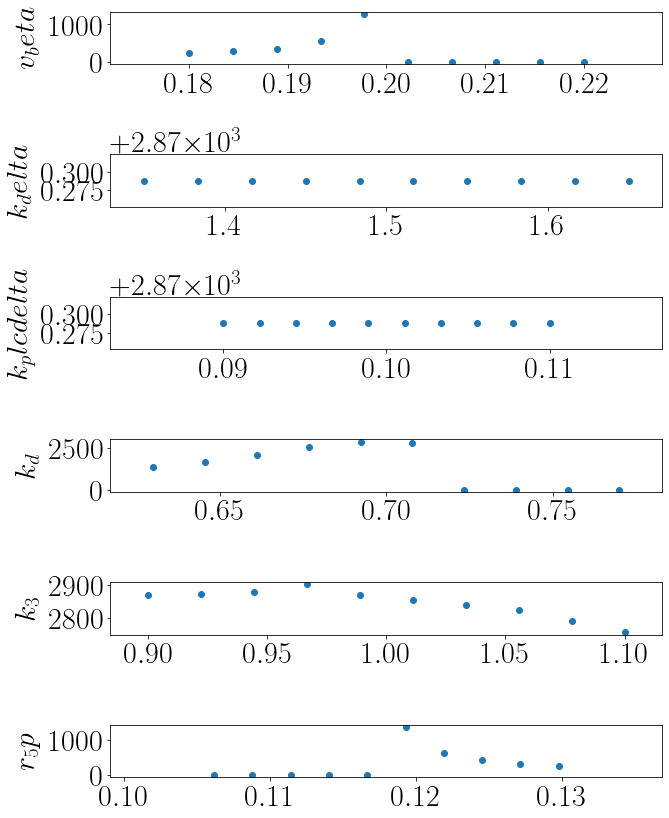

In [309]:
fig, ax = plt.subplots(len(p_parameters), 1, figsize=(10, len(p_parameters*2)))
for i, param in enumerate(p_parameters):
    ax[i].scatter(wiggle_results[param]['param_vals'], wiggle_results[param]['delay'])
    ax[i].set_ylabel('$' + param + '$')
plt.tight_layout()

## h params

In [312]:
h_parameters = ['d1', 'd2', 'd3', 'd5', 'a2']


In [313]:
#wiggle parameters
wiggle_factor = 0.1 #wiggle by +/- 10%
wiggle_trials = 10
input_max = 0.2133
input_duration = 3000

h_wiggle_results = {}

for param in h_parameters:
    h_wiggle_results[param] = {
        'param_vals': [],
        'delay': []
    }

for param in h_parameters:
    print('Wiggling parameter: ' + param)
    param_init = globals()[param]
    param_range = np.linspace(param_init*(1-wiggle_factor), param_init*(1+wiggle_factor), wiggle_trials)

    for param_val in param_range:
        globals()[param] = param_val
        run_Gstar_controlled_experiment('pulse', t_f=input_duration, max_step=0.5)
        abs_delay, rel_delay = compute_delay()
        h_wiggle_results[param]['delay'].append(abs_delay)
        
    h_wiggle_results[param]['param_vals'] = param_range
    globals()[param] = param_init

Wiggling parameter: d1
Wiggling parameter: d2
Wiggling parameter: d3
Wiggling parameter: d5
Wiggling parameter: a2


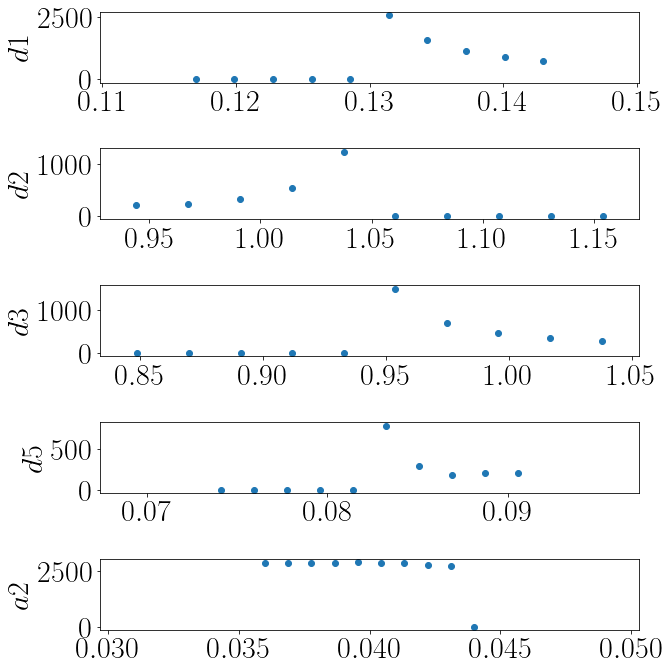

In [314]:
fig, ax = plt.subplots(len(h_parameters), 1, figsize=(10, len(h_parameters*2)))
for i, param in enumerate(h_parameters):
    ax[i].scatter(h_wiggle_results[param]['param_vals'], h_wiggle_results[param]['delay'])
    ax[i].set_ylabel('$' + param + '$')
plt.tight_layout()

## c params

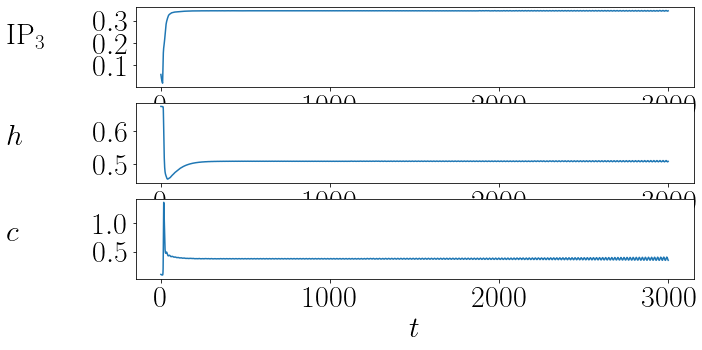

In [319]:
a2 = 0.045
input_max = 0.213
run_Gstar_controlled_experiment('pulse', t_f=3000, max_step=0.05)

fig, ax = plt.subplots(3, 1, figsize=(10, 5))
plot_experiment_plots(['p', 'h', 'c'], ax, plot_input=False)
a_2 = 0.04

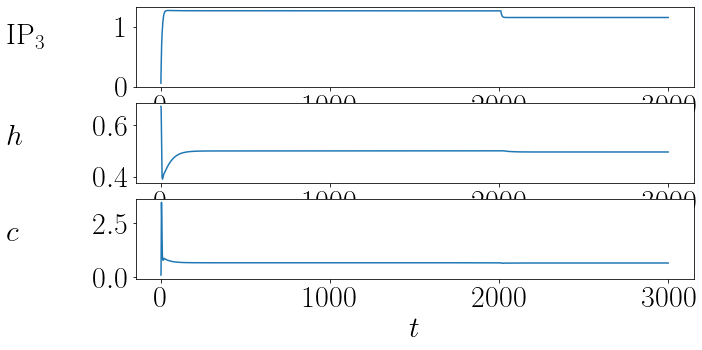

In [332]:
v_3k = 0
v_delta = 0.2
input_max = 0.1
run_Gstar_controlled_experiment('pulse', t_f=3000, max_step=0.05)

fig, ax = plt.subplots(3, 1, figsize=(10, 5))
plot_experiment_plots(['p', 'h', 'c'], ax, plot_input=False)


In [333]:
compute_delay()

(0, 0)

In [317]:
c_parameters = ['v_ip3r', 'v_er_leak', 'v_in', 'k_out', 'v_serca', 'k_serca', 'v_pmca', 'k_pmca', 'v_soc', 'k_soc']


In [318]:
#wiggle parameters
wiggle_factor = 0.1 #wiggle by +/- 10%
wiggle_trials = 10
input_max = 0.2133
input_duration = 3000

c_wiggle_results = {}

for param in c_parameters:
    c_wiggle_results[param] = {
        'param_vals': [],
        'delay': []
    }

for param in c_parameters:
    print('Wiggling parameter: ' + param)
    param_init = globals()[param]
    param_range = np.linspace(param_init*(1-wiggle_factor), param_init*(1+wiggle_factor), wiggle_trials)

    for param_val in param_range:
        globals()[param] = param_val
        run_Gstar_controlled_experiment('pulse', t_f=input_duration, max_step=0.5)
        abs_delay, rel_delay = compute_delay()
        c_wiggle_results[param]['delay'].append(abs_delay)
        
    c_wiggle_results[param]['param_vals'] = param_range
    globals()[param] = param_init

Wiggling parameter: v_ip3r
Wiggling parameter: v_er_leak
Wiggling parameter: v_in
Wiggling parameter: k_out
Wiggling parameter: v_serca
Wiggling parameter: k_serca
Wiggling parameter: v_pmca
Wiggling parameter: k_pmca
Wiggling parameter: v_soc
Wiggling parameter: k_soc


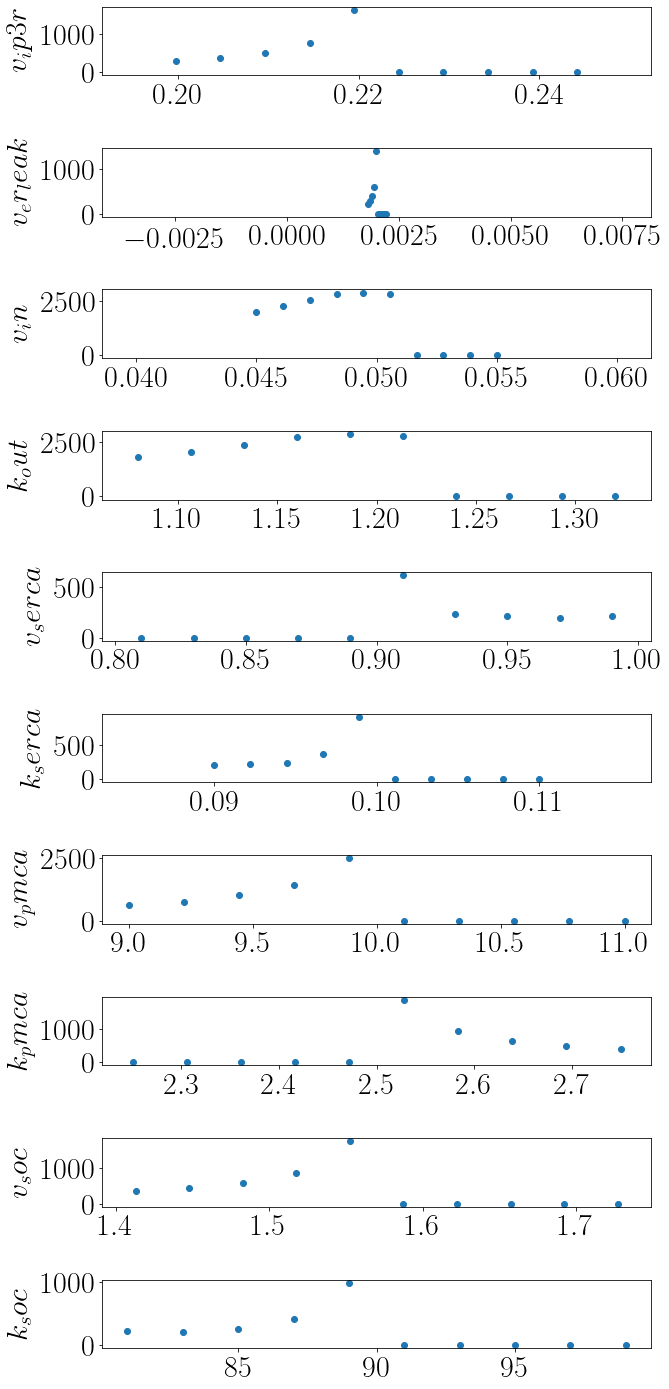

In [322]:
fig, ax = plt.subplots(len(c_parameters), 1, figsize=(10, len(c_parameters*2)))
for i, param in enumerate(c_parameters):
    ax[i].scatter(c_wiggle_results[param]['param_vals'], c_wiggle_results[param]['delay'])
    ax[i].set_ylabel('$' + param + '$')
plt.tight_layout()

# Constructing Jacobian of system

In [193]:
c = 0.4
c_tot = 22
h = 0.6
p = 0.2
c_er = c_tot - c

In [203]:

def compute_jacob(c, c_tot, h, p):
    '''
    Compute the Jacobian of the system at a given point
    '''

    c_er = c_tot - c

    '''
    Compute derivatives of cdot with respect to each of the variables
    '''
    # df_c/dc
    dJ_ip3r_dc = v_ip3r * h**3 * (p/(p+d1))**3  *  (c_tot*3*(c**2)*d5/(c+d5)**4 
                                                       - 2*(c**3)/(c+d5)**3 - 6*(c**3)*d5/(c+d5)**4)
    dJ_er_leak_dc = -2*v_er_leak
    dJ_serca_dc = 1.75*(c**0.75)*(k_serca**1.75) / (c**1.75 + k_serca**1.75)**2
    dJ_ecs_add_dc = k_out
    dJ_pmca_dc = 2*v_pmca*(c * k_pmca**2)/(c**2 + k_pmca**2)**2
    dJ_soc_dc = 4*v_soc*(k_soc**4)*(c_er**3)/(k_soc**4 + c_er**4)**2

    dfc_dc = dJ_ip3r_dc + dJ_er_leak_dc - dJ_serca_dc + delta*(dJ_ecs_add_dc - dJ_pmca_dc + dJ_soc_dc)

    #df_c/dctot
    dJ_ip3r_dctot = v_ip3r*(h**3)*(p/(p+d1))**3 * (c/(c+d5))**3
    dJ_er_leak_dctot = v_er_leak
    dJ_serca_dctot = 0
    dJ_ecs_add_dctot = 0
    dJ_pmca_dctot = 0
    dJ_soc_dctot = -4*v_soc*(k_soc**4)*(c_er**3)/(k_soc**4 + c_er**4)**2

    dfc_dctot = dJ_ip3r_dctot + dJ_er_leak_dctot - dJ_serca_dctot + delta*(dJ_ecs_add_dctot - 
                                                                           dJ_pmca_dctot + dJ_soc_dctot)

    #df_c/dh
    dJ_ip3r_dh = 3*v_ip3r*(h**2)*(p/(p+d1))**3 * (c/(c+d5))**3 * (c_er-c)
    dJ_er_leak_dh = 0
    dJ_serca_dh = 0
    dJ_ecs_add_dh = 0
    dJ_pmca_dh = 0
    dJ_soc_dh = 0

    dfc_dh = dJ_ip3r_dh + dJ_er_leak_dh - dJ_serca_dh + delta*(dJ_ecs_add_dh - dJ_pmca_dh + dJ_soc_dh)

    #df_c/dp
    dJ_ip3r_dp = v_ip3r*(h**3)* 3*(p**2)*d1/(p+d1)**4 * (c/(c+d5))**3
    dJ_er_leak_dp = 0
    dJ_serca_dp = 0
    dJ_ecs_add_dp = 0
    dJ_pmca_dp = 0
    dJ_soc_dp = 0

    dfc_dp = dJ_ip3r_dp + dJ_er_leak_dp - dJ_serca_dp + delta*(dJ_ecs_add_dp - dJ_pmca_dp + dJ_soc_dp)


    '''
    The derivatives of c_tot dot use the same dJ_ecs_add, dJ_pmca, dJ_soc as the derivatives of cdot
    '''
    dfctot_dc = delta*(dJ_ecs_add_dc - dJ_pmca_dc + dJ_soc_dc)
    dfctot_dctot = delta*(dJ_ecs_add_dctot - dJ_pmca_dctot + dJ_soc_dctot)
    dfctot_dh = delta*(dJ_ecs_add_dh - dJ_pmca_dh + dJ_soc_dh)
    dfctot_dp = delta*(dJ_ecs_add_dp - dJ_pmca_dp + dJ_soc_dp)

    '''
    Compute derivatives of hdot with respect to each of the variables
    '''
    Q2 = d2 * (p + d1) / (p + d3)
    h_inf = Q2 / (Q2 + c)
    tau_h = 1 / (a2 * (Q2 + c))

    dfh_dctot = 0
    dfh_dh = -1/tau_h

    dQ2_dp = d2*(d3-d1)/(p+d3)**2
    dhinf_dc = -Q2/(Q2+c)**2
    dhinf_dp = Q2*c/(Q2+c)**2 * dQ2_dp
    dtauh_dc = -a2/(a2*Q2 + a2*c)**2
    dtauh_dp = -a2/(a2*Q2 + a2*c)**2 * dQ2_dp

    dfh_dp = dhinf_dp*tau_h - dtauh_dp*h_inf / tau_h**2
    dfh_dc = dhinf_dc*tau_h - dtauh_dc*h_inf / tau_h**2

    '''
    Compute derivatives of pdot with respect to each of the variables
    '''
    dfp_dh = 0
    dfp_dctot = 0

    dp_prod_dp = -v_delta*(k_delta/(1+p)**2)*(c**2/(c**2 + k_plcdelta**2))
    dp_deg_dp = v_3k*(c**4/(c**4 + k_d**4))*(p*k_3/(p+k_3)**2) + r_5p

    dfp_dp = dp_prod_dp - dp_deg_dp

    dp_prod_dc = v_delta*(k_delta/(1+p))*(2*c*k_plcdelta**2)/(c**2 + k_plcdelta**2)
    dp_deg_dc = v_3k*(4*c**3 *k_d**4 / (c**4 + k_d**4))*(p/(p+k_3))

    dfp_dc = dp_prod_dc - dp_deg_dc

    '''
    Construct Jacobian
    '''
    jacob = np.array([
        [dfc_dc, dfc_dctot, dfc_dh, dfc_dp],
        [dfctot_dc, dfctot_dctot, dfctot_dh, dfctot_dp],
        [dfh_dc, dfh_dctot, dfh_dh, dfh_dp],
        [dfp_dc, dfp_dctot, dfp_dh, dfp_dp],
    ])
    
    return jacob

In [204]:
compute_jacob(0.4, 20, 0.4, 0.4)

array([[-2.55014347e-01,  5.33992203e-03,  5.01612029e-01,
         6.40817254e-03],
       [-3.23597514e-03, -1.43494833e-04,  0.00000000e+00,
         0.00000000e+00],
       [-1.91728981e+01,  0.00000000e+00, -3.25541164e-02,
         3.63937099e+00],
       [-1.32191193e-01,  0.00000000e+00,  0.00000000e+00,
        -1.57326231e-01]])

In [202]:
np.linalg.eigvals(jacob)

array([-0.09425363+3.74972445j, -0.09425363-3.74972445j,
       -0.16492632+0.j        , -0.00019169+0.j        ])